# Baseline
---

Vamos a construir un modelo muy sencillo para saber qué es lo peor que podemos hacer, en general esta es una tarea muy importante que queremos que repitan en sus proyectos de machine learning. ¿Por qué?

* Navaja de Ockam: “Cuando se ofrecen dos o más explicaciones de un fenómeno, es preferible la explicación completa más simple; es decir, no deben multiplicarse las entidades sin necesidad.” ¿Para qué desarrollar un modelo super complejo si capaz es peor o casi igual que uno muy sencillo?
* Nos sirve para saber si estamos usando bien los modelos más complejos, si su score nos da peor al baseline probablemente se deba a un error de código.
* Nos sirve para rápidamente saber que tan complejo es un problema.
* Los modelos simples son fáciles de entender.
* Utilice todas las columnas del dataset (exceptuando columnas que no tenga sentido usar para predecir) con algún encoding donde sea necesario para entrenar una regresión logística, utilizando búsqueda de hiperparametros y garantizando la reproducibilidad de los resultados cuando el notebook corriera varias veces. Conteste las preguntas:

* ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)
    * Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)
    * ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

**Data transformation for machine learning**. The data are split into training and testing sets for the binary classification task. It is imperative to explicitly encode all values in both data into numerical values. This is due to the classifiers implementation which only accepts numerical values as input. The binary class is label encoded using sklearn’s functionality. For instance, the value poisonous: p is encoded as 1 and edible: e as 0. The quantitative variables remain unchanged, while the nominal variables are one-hot encoded.

**Training and testing data sets** are prepared using the standard Pareto principle. The training set is randomly sampled without substitution, it represents 80% of the data. The remaining 20% are used as a test set. To further assess the predictive performance of the machine learning models on the data, a five-fold cross-validation is employed.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('data/secondary_data.csv', sep=';')
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


In [3]:
df.count()

class                   61069
cap-diameter            61069
cap-shape               61069
cap-surface             46949
cap-color               61069
does-bruise-or-bleed    61069
gill-attachment         51185
gill-spacing            36006
gill-color              61069
stem-height             61069
stem-width              61069
stem-root                9531
stem-surface            22945
stem-color              61069
veil-type                3177
veil-color               7413
has-ring                61069
ring-type               58598
spore-print-color        6354
habitat                 61069
season                  61069
dtype: int64

### Set de Validación

Se puede obtener dividiendo el set de entrenamiento aleatoriamente porque el set no tiene un orden en particular. Si tuviera un orden, de tiempo por ejemplo, no se podría hacer esto porque el modelo aprendería de datos del futuro produciendo Time Travel.

In [4]:
# Lleno los valores faltantes con el mismo valor.
df.fillna('#', inplace=True)

# Separo los datos en train y validation.
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
# Encodeo las variables categoricas.
be = BinaryEncoder()
X_train = be.fit_transform(X_train)
X_validation = be.transform(X_validation)

columnas_encodeadas = X_train.columns

# Encodeo la variable target.
ohe = OneHotEncoder(drop='first')
y_train = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()[:,0]
y_validation = ohe.transform(y_validation.values.reshape(-1,1)).toarray()[:,0]

# Escalo los datos.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

## Busqueda de Hiper-parametros

In [6]:
lr = LogisticRegression(max_iter=1000, random_state=123)

params = {
    'penalty': ['l2'],
    'C': [3.45, 3.49, 3.5, 3.51, 3.55],
}

gs = GridSearchCV(lr, param_grid=params, scoring='roc_auc')
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=123),
             param_grid={'C': [3.45, 3.49, 3.5, 3.51, 3.55, 3.6],
                         'penalty': ['l2']},
             scoring='roc_auc')

In [7]:
gs.best_params_

{'C': 3.5, 'penalty': 'l2'}

In [8]:
lr = gs.best_estimator_
lr.fit(X_train, y_train)

LogisticRegression(C=3.5, max_iter=1000, random_state=123)

In [9]:
preds = lr.predict(X_validation)
preds

array([0., 1., 1., ..., 0., 0., 1.])

## Matriz de Confusión

Text(45.25, 0.5, 'Real')

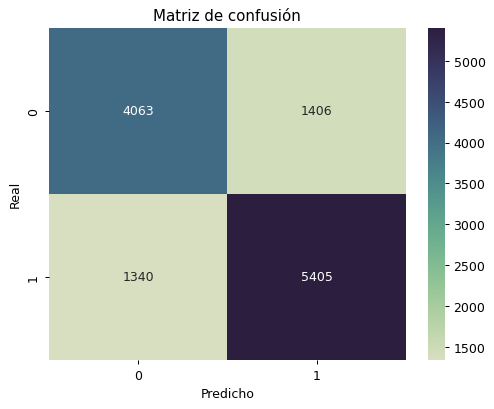

In [10]:
cm = confusion_matrix(y_validation, preds)
plt.figure(dpi=90)
sns.heatmap(cm, annot=True, fmt='g', cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [11]:
print(f'Puntaje auc_roc: {roc_auc_score(y_validation, preds)}')

Puntaje auc_roc: 0.7721244656688192


## Importancia de las Features

In [12]:
features = pd.DataFrame({'feature': columnas_encodeadas, 'importance': lr.coef_[0]})
features.feature = features.feature.map(lambda x: x.split('_')[0])
features.importance = features.importance.map(abs)
features = features.groupby('feature').sum().reset_index()
features

,feature,importance
0,cap-color,0.967850
1,cap-diameter,0.194231
2,cap-shape,0.464010
3,cap-surface,1.146280
4,does-bruise-or-bleed,0.133813
5,gill-attachment,1.316896
6,gill-color,0.640531
7,gill-spacing,2.687344
8,habitat,0.977798
9,has-ring,0.702131


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'cap-color'),
  Text(1, 0, 'cap-diameter'),
  Text(2, 0, 'cap-shape'),
  Text(3, 0, 'cap-surface'),
  Text(4, 0, 'does-bruise-or-bleed'),
  Text(5, 0, 'gill-attachment'),
  Text(6, 0, 'gill-color'),
  Text(7, 0, 'gill-spacing'),
  Text(8, 0, 'habitat'),
  Text(9, 0, 'has-ring'),
  Text(10, 0, 'ring-type'),
  Text(11, 0, 'season'),
  Text(12, 0, 'spore-print-color'),
  Text(13, 0, 'stem-color'),
  Text(14, 0, 'stem-height'),
  Text(15, 0, 'stem-root'),
  Text(16, 0, 'stem-surface'),
  Text(17, 0, 'stem-width'),
  Text(18, 0, 'veil-color'),
  Text(19, 0, 'veil-type')])

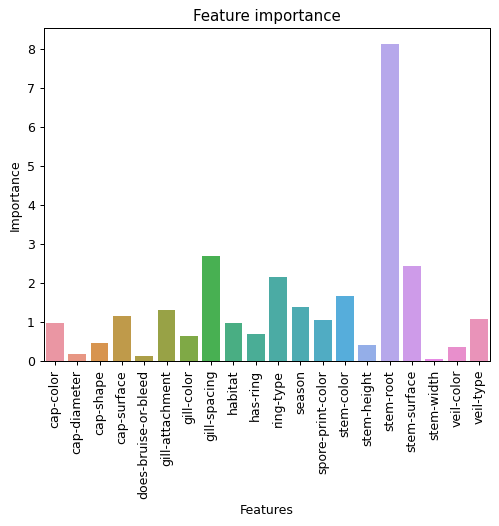

In [13]:
plt.figure(dpi=90)
sns.barplot(features, x='feature', y='importance')
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)

In [14]:
df = pd.DataFrame(X_validation, columns=columnas_encodeadas)
df['class'] = y_validation
df

,cap-diameter,cap-shape_0,cap-shape_1,cap-shape_2,cap-surface_0,cap-surface_1,cap-surface_2,cap-surface_3,cap-color_0,cap-color_1,...,spore-print-color_2,spore-print-color_3,habitat_0,habitat_1,habitat_2,habitat_3,season_0,season_1,season_2,class
0,0.055505,-0.572442,0.469856,-0.976232,1.403534,-0.65011,-1.198810,1.058901,-0.635705,-0.575026,...,-0.253502,0.283227,-0.043672,-0.353358,0.547715,-0.530702,-0.215180,0.849709,-0.926909,0.0
1,-0.838040,-0.572442,0.469856,1.024347,-0.712487,-0.65011,0.834161,1.058901,-0.635705,-0.575026,...,-0.253502,0.283227,-0.043672,-0.353358,-1.825766,1.884298,-0.215180,-1.176874,1.078855,1.0
2,-0.488970,1.746902,-2.128312,1.024347,1.403534,-0.65011,-1.198810,-0.944375,-0.635705,1.739051,...,-0.253502,0.283227,-0.043672,-0.353358,0.547715,-0.530702,4.647271,-1.176874,-0.926909,1.0
3,0.144670,-0.572442,0.469856,1.024347,-0.712487,1.53820,0.834161,1.058901,1.573056,1.739051,...,-0.253502,0.283227,-0.043672,-0.353358,0.547715,-0.530702,-0.215180,0.849709,-0.926909,0.0
4,-0.451027,-0.572442,0.469856,-0.976232,-0.712487,-0.65011,0.834161,1.058901,1.573056,-0.575026,...,-0.253502,0.283227,-0.043672,-0.353358,-1.825766,1.884298,-0.215180,0.849709,-0.926909,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12209,-0.572443,-0.572442,0.469856,1.024347,-0.712487,-0.65011,0.834161,1.058901,-0.635705,-0.575026,...,-0.253502,0.283227,-0.043672,2.829991,-1.825766,-0.530702,-0.215180,0.849709,-0.926909,1.0
12210,-0.416879,-0.572442,0.469856,1.024347,1.403534,-0.65011,0.834161,-0.944375,-0.635705,-0.575026,...,-0.253502,0.283227,-0.043672,2.829991,-1.825766,1.884298,-0.215180,-1.176874,1.078855,1.0
12211,1.521982,-0.572442,0.469856,1.024347,1.403534,-0.65011,-1.198810,-0.944375,-0.635705,1.739051,...,-0.253502,-3.530736,-0.043672,-0.353358,0.547715,-0.530702,-0.215180,0.849709,1.078855,0.0
12212,1.478348,-0.572442,0.469856,-0.976232,-0.712487,1.53820,0.834161,1.058901,-0.635705,-0.575026,...,-0.253502,0.283227,-0.043672,-0.353358,-1.825766,1.884298,-0.215180,-1.176874,1.078855,0.0
